In [1]:
from  scipy.special import j1
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 1631

snap_info=Snap_Info()

Thelen = Boxlen/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+snap_info.get_redshift(Snapshot))**2/h  # proj mom: km/h -> dkSZ/CMB

the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

n_halo =np.array([    1,     2,     3,     5,    7,     9,    30,   70])*10**-4 #8
lgM_min=np.array([12.86, 12.68, 12.55, 12.41, 12.3, 12.23, 11.82, 11.5])

In [2]:
Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm

In [5]:
thetap = vel2theta(velp, Boxlen)
del momp, denp, velp

In [3]:
cmb_map_act = cmb2d(thelen=Thelen, grid = Grid, Delta_T=cmbsur[0][0],sigma=cmbsur[0][1])

In [4]:
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm

In [ ]:
filename

In [ ]:
#'''
mass_selection_label1 = 1
mass_selection_label2 = 1
den_method = 0   #NGP
vel_method = 0   #thetap


for i in range(len(lgM_min)):
    mass_selection_label1 = i

    N_jk = 100
    the_ap = np.linspace(1, 6, 10)

    lgM_min1= lgM_min[mass_selection_label1]
    n_halo1 = n_halo[mass_selection_label1]
    label1 = np.where(halo_mass>10**lgM_min1)[0]
    print("Halo sample to reconstruct vel: n = "+str(n_halo1*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min1))
    print("N=",len(label1))

    #del velp, denp, momp
    haloxx_rsd=add_RSD(halox[label1,:]*Boxlen,halov[label1,:]*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
    # for 1
    if den_method == 0:
        denh_rsd=den_NGP(haloxx_rsd,Grid)

    #for 2
    if vel_method == 0:
        #thetap = vel2theta(velp, Boxlen)
        W,kx,ky,kz=wiener_filter_theta_esti(denh_rsd,thetap, Boxlen)
        #del thetap
        thetah_rsd_rec=wiener_filter_den2theta(denh_rsd,W,kx,ky,kz, Boxlen)
        #del W,kx,ky,kz
        velh_rsd_rec=theta2vel(thetah_rsd_rec, Boxlen)

    for j in range(len(lgM_min)-2, len(lgM_min)):
        mass_selection_label2 = j
        filename = "stack_prediction_results/den"+str(den_method)+"vel"+str(vel_method)+"l"+str(mass_selection_label1)+"l"+str(mass_selection_label2)
        print(filename)
        
        #for 3
        lgM_min2 = lgM_min[mass_selection_label2]
        label2 = np.where(halo_mass>10**lgM_min2)[0]
        n_halo2 = n_halo[mass_selection_label2]
        print("Halo sample to stack: n = "+str(n_halo2*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min1))
        #'''

        stack_signal, stack_null, r_true_rec, r_ksz_rec = cal_stack_kSZ_signal_proj1_jk(the_ap = the_ap, CMB_map = momp_proj+cmb_map_act, vel_rec=velh_rsd_rec, halox=halox[label2,:], halov=halov[label2, :], the_los=the_los, N_jk=N_jk, thelen=Thelen, grid = Grid)
        stack_mean, corv = error_esti_jackknife(stack_signal)
        C_ = pseudo_inverse(corv,2)
        chi_null = cal_chi_square(stack_mean, stack_mean, C_)
        
        print(label1, label2, "S/N=",np.round(np.sqrt(chi_null), 2))
        np.savez(filename, stack_signal=stack_signal, stack_null=stack_null, r_true_rec =r_true_rec, r_ksz_rec=r_ksz_rec)

Halo sample to reconstruct vel: n = 1.0$10^{-4}$ lgM_min 12.86
N= 160857
stack_prediction_results/den0vel0l0l6
Halo sample to stack: n = 30.0$10^{-4}$ lgM_min 12.86
rv= 0.7864132385924694
r: [0.00350928 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


r: [0.00350928 0.00384769 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


r: [0.00350928 0.00384769 0.00401618 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.00350136
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.00350136
 0.00342014 0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.00350136
 0.00342014 0.0034017  0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.00350136
 0.00342014 0.0034017  0.00339219 0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00350928 0.00384769 0.00401618 0.0039083  0.0036803  0.00350136
 0.00342014 0.0034017  0.00339219 0.00336273]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


[     0      1      2 ... 160854 160855 160856] [      0       1       2 ... 4926347 4926348 4926349] S/N= 10.25
stack_prediction_results/den0vel0l0l7
Halo sample to stack: n = 70.0$10^{-4}$ lgM_min 12.86
rv= 0.7843622783819828
r: [0.00275136 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


r: [0.00275136 0.00300648 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


r: [0.00275136 0.00300648 0.00312247 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.0026408
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.0026408
 0.00255192 0.         0.         0.        ]


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.0026408
 0.00255192 0.00252423 0.         0.        ]


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.0026408
 0.00255192 0.00252423 0.00251831 0.        ]


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


r: [0.00275136 0.00300648 0.00312247 0.00301616 0.00281052 0.0026408
 0.00255192 0.00252423 0.00251831 0.0025071 ]


100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


[     0      1      2 ... 160854 160855 160856] [       0        1        2 ... 11636103 11636104 11636105] S/N= 12.18
Halo sample to reconstruct vel: n = 2.0$10^{-4}$ lgM_min 12.68
N= 327197
stack_prediction_results/den0vel0l1l6
Halo sample to stack: n = 30.0$10^{-4}$ lgM_min 12.68
rv= 0.8139259598202386
r: [0.00377372 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


r: [0.00377372 0.00405836 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00377372 0.00405836 0.00415195 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.0035545
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.0035545
 0.00350328 0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.0035545
 0.00350328 0.00352074 0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.0035545
 0.00350328 0.00352074 0.00354514 0.        ]


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


r: [0.00377372 0.00405836 0.00415195 0.00397956 0.00372425 0.0035545
 0.00350328 0.00352074 0.00354514 0.00354528]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


[     0      1      2 ... 327194 327195 327196] [      0       1       2 ... 4926347 4926348 4926349] S/N= 10.62
stack_prediction_results/den0vel0l1l7
Halo sample to stack: n = 70.0$10^{-4}$ lgM_min 12.68
rv= 0.812232877163497
r: [0.00288453 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.00270967
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.00270967
 0.00265247 0.         0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.00270967
 0.00265247 0.00265969 0.         0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.00270967
 0.00265247 0.00265969 0.00268738 0.        ]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


r: [0.00288453 0.00311177 0.00319353 0.00306428 0.00285885 0.00270967
 0.00265247 0.00265969 0.00268738 0.00270626]


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


[     0      1      2 ... 327194 327195 327196] [       0        1        2 ... 11636103 11636104 11636105] S/N= 12.42
Halo sample to reconstruct vel: n = 3.0000000000000004$10^{-4}$ lgM_min 12.55
N= 507861
stack_prediction_results/den0vel0l2l6
Halo sample to stack: n = 30.0$10^{-4}$ lgM_min 12.55
rv= 0.8276616919811591
r: [0.00378809 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00378809 0.00404871 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00378809 0.00404871 0.00411342 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.0034427
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.0034427
 0.00336049 0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.0034427
 0.00336049 0.00334312 0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.0034427
 0.00336049 0.00334312 0.003334   0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00378809 0.00404871 0.00411342 0.00391519 0.00363743 0.0034427
 0.00336049 0.00334312 0.003334   0.00330598]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[     0      1      2 ... 507858 507859 507860] [      0       1       2 ... 4926347 4926348 4926349] S/N= 10.38
stack_prediction_results/den0vel0l2l7
Halo sample to stack: n = 70.0$10^{-4}$ lgM_min 12.55
rv= 0.8259745991844064
r: [0.00279518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.00253053
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.00253053
 0.00245799 0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.00253053
 0.00245799 0.0024489  0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.00253053
 0.00245799 0.0024489  0.00246133 0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00279518 0.00300141 0.00306033 0.00291293 0.00269347 0.00253053
 0.00245799 0.0024489  0.00246133 0.00246775]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


[     0      1      2 ... 507858 507859 507860] [       0        1        2 ... 11636103 11636104 11636105] S/N= 12.3
Halo sample to reconstruct vel: n = 5.0$10^{-4}$ lgM_min 12.41
N= 823120
stack_prediction_results/den0vel0l3l6
Halo sample to stack: n = 30.0$10^{-4}$ lgM_min 12.41
rv= 0.8408116785693935
r: [0.00368571 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00368571 0.00395439 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.0032925
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.0032925
 0.00317388 0.         0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.0032925
 0.00317388 0.00312809 0.         0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.0032925
 0.00317388 0.00312809 0.00310251 0.        ]


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


r: [0.00368571 0.00395439 0.00402573 0.00382244 0.00352215 0.0032925
 0.00317388 0.00312809 0.00310251 0.00306867]


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[     0      1      2 ... 823117 823118 823119] [      0       1       2 ... 4926347 4926348 4926349] S/N= 10.06
stack_prediction_results/den0vel0l3l7
Halo sample to stack: n = 70.0$10^{-4}$ lgM_min 12.41
rv= 0.8390082419513386
r: [0.00275753 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


r: [0.00275753 0.00296367 0.         0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


r: [0.00275753 0.00296367 0.0030151  0.         0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


r: [0.00275753 0.00296367 0.0030151  0.00284814 0.         0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00275753 0.00296367 0.0030151  0.00284814 0.00259864 0.
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00275753 0.00296367 0.0030151  0.00284814 0.00259864 0.00240217
 0.         0.         0.         0.        ]


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


r: [0.00275753 0.00296367 0.0030151  0.00284814 0.00259864 0.00240217
 0.00230032 0.         0.         0.        ]


 17%|█▋        | 17/100 [00:28<02:19,  1.68s/it]

Halo sample to reconstruct vel: n = 2.0$10^{-4}$ lgM_min 12.68
rv= 0.8526146965717035
r: 0.005924997679336001


100%|██████████| 100/100 [00:03<00:00, 31.85it/s]


r: 0.006343444601628136


100%|██████████| 100/100 [00:04<00:00, 24.21it/s]


r: 0.0064370726159166496


100%|██████████| 100/100 [00:04<00:00, 23.04it/s]


r: 0.006049492599499909


100%|██████████| 100/100 [00:05<00:00, 17.78it/s]


r: 0.005416924526475862


100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


r: 0.004780899216907501


100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


r: 0.004238502419875823


100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


r: 0.0038205676046363995


100%|██████████| 100/100 [00:04<00:00, 22.19it/s]


r: 0.003545225072877039


100%|██████████| 100/100 [00:04<00:00, 21.37it/s]


r: 0.003421140874479349


100%|██████████| 100/100 [00:03<00:00, 25.92it/s]


29.62256644525654 5.442661705935483


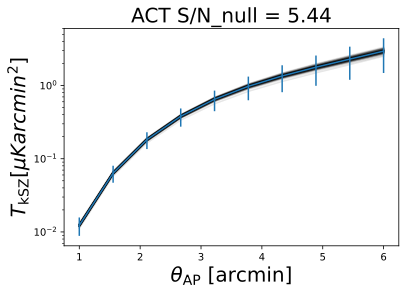

In [17]:
mass_selection_label1 = 1
#mass_selection_label2 = 1
den_method = 0   #NGP
vel_method = 0   #thetap
CMB_survey = "ACT"

pkden,kden=fa.CalPS(denp,Grid,mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)
velp = momden2vel(denp, momp)
thetap = vel2theta(velp, Boxlen)

for i in range(len(lgM_min)):
    mass_selection_label1 = i

    lgM_min1= lgM_min[mass_selection_label1]
    n_halo1 = n_halo[mass_selection_label1]
    label1 = np.where(halo_mass>10**lgM_min1)[0]
    print("Halo sample to reconstruct vel: n = "+str(n_halo1*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min1))
    print("N=",len(label1))
    
    #del velp, denp, momp
    haloxx_rsd=add_RSD(halox[label1,:]*Boxlen,halov[label1,:]*(1+snap_info.get_redshift(Snapshot)),n_rsd,cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h
    denh_rsd=den_NGP(haloxx_rsd,Grid)
    W,kx,ky,kz=wiener_filter_theta_esti(denh_rsd,thetap, Boxlen)
    #del thetap
    thetah_rsd_rec=wiener_filter_den2theta(denh_rsd,W,kx,ky,kz, Boxlen)
    #del W,kx,ky,kz
    velh_rsd_rec=theta2vel(thetah_rsd_rec, Boxlen)
    
    
    denh_rsd_fw = wiener_filter_den(denh_rsd,pkden,kden,2*np.pi/Boxlen,40*10**-4,Grid)
    
    momh_rsd_rec=velh_rsd_rec*(denh_rsd_fw).reshape(Grid,Grid,Grid,1)
    momh_rsd_rec_proj = proj1(momh_rsd_rec, the_los)*cnorm

    cor, l = fa.CalCor2d(momh_rsd_rec_proj, momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps_rec, l = fa.CalPS2d(momh_rsd_rec_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    ps, l = fa.CalPS2d(momp_proj, Grid, mapscale=(Thelen/Grid**2)**2,kscale=2*np.pi/Thelen)
    
    CMB_survey = "ACT"
    l_array, NS, SN = SN_prediction_tomography(l=l, cor=cor, PS_rec=ps_rec, f_sky=1400/(4*np.pi*(180/np.pi)**2), CMB_survey=CMB_survey)
    print("S/N", SN)
    
    filename = "tomography_prediction_results/den"+str(den_method)+"vel"+str(vel_method)+"l"+str(mass_selection_label1)
    np.savez(filename, l=l, cor=cor, ps_rec=ps_rec, ps=ps, l_array=l_array, NS=NS, SN=SN)

In [ ]:

SN  = np.zeros((len(lgM_min), len(lgM_min)))

for i in range(len(lgM_min)):
    for j in range(len(lgM_min)):
        filename = "stack_prediction_results/den"+str(den_method)+"vel"+str(vel_method)+"l"+str(i)+"l"+str(j)+".npz"
        d = np.load(filname)

        stack_signal = d["stack_signal"]
        stack_null = d["stack_null"]
        stack_mean, corv = error_esti_jackknife(stack_signal)
        C_ = pseudo_inverse(corv,2)
        chi_null = cal_chi_square(stack_mean, stack_mean, C_)
        SN[i, j] = np.sqrt(chi_null)

        
fig, ax = plt.subplots()
im = ax.imshow(SN) 

label_nhalo = ["%.4f" % number for number in n_halo]
ax.set_xticks(np.arange(len(lgM_min)), labels=label_nhalo)
ax.set_yticks(np.arange(len(lgM_min)), labels=label_nhalo)

ax.set_xlabel("Halos for velocity reconstruction "+r"$\times 10^{-3}$")
ax.set_ylabel("Halos for stacking "+r"$\times 10^{-3}$")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(lgM_min)):
    for j in range(len(lgM_min)):
        text = ax.text(j, i, SN[i, j], ha="center", va="center", color="w")


plt.show()